In [ ]:
%run run_new.py 1

In [ ]:
%run real_data_exchange_linux.py 1

In [ ]:
%run run_TS_fineTune.py 1

/Users/zhanggangquan/miniconda3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 1  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer



/Users/zhanggangquan/miniconda3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Read data into pandas DataFrame
url = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True,usecols=[0,1])

# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set


In [ ]:
df

,A
2021-01-01 00:00:00,-1.3378
2021-01-01 01:00:00,-1.6111
2021-01-01 02:00:00,-1.9259
2021-01-01 03:00:00,-1.9184
2021-01-01 04:00:00,-1.9168
...,...
2021-01-10 19:00:00,0.7328
2021-01-10 20:00:00,0.4957
2021-01-10 21:00:00,-0.1209
2021-01-10 22:00:00,-0.5072


In [5]:

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST,  # number of windows in rolling window evaluation
    distance=1,  # number of time steps between each window - distance=PDT for non-overlapping windows
)


In [6]:

# Prepare pre-trained model by downloading model weights from huggingface hub
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )


In [7]:

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)


In [ ]:

# inp = next(input_it)
# label = next(label_it)
# forecast = next(forecast_it)


In [8]:
forecast = next(forecast_it)
forecast

gluonts.model.forecast.SampleForecast(info=None, item_id='A', samples=array([[0.613533  ],
       [0.44012418],
       [0.771653  ],
       [0.17043065],
       [0.46783337],
       [0.59612995],
       [0.59062797],
       [0.6047426 ],
       [0.4437424 ],
       [0.9573697 ],
       [0.58569443],
       [0.49121612],
       [0.6367765 ],
       [0.6452157 ],
       [0.6074451 ],
       [0.4689648 ],
       [0.35645685],
       [0.50022334],
       [0.27719873],
       [0.72419316],
       [0.53756183],
       [0.4673285 ],
       [0.50273395],
       [0.75066185],
       [0.52488357],
       [0.38493642],
       [0.58781654],
       [0.16844995],
       [0.5686702 ],
       [0.486057  ],
       [0.4105735 ],
       [0.40579876],
       [0.45595574],
       [0.54144955],
       [0.5398131 ],
       [0.732259  ],
       [0.8093574 ],
       [0.5176901 ],
       [0.5210985 ],
       [0.5141467 ],
       [0.7096054 ],
       [0.57302666],
       [0.45092085],
       [0.51523423],
      

In [14]:
forecast.median[0]

0.52488357

In [ ]:
forecast_result = []
for i in range(TEST):
    # inp = next(input_it)
    # label = next(label_it)
    forecast = next(forecast_it)
    forecast_result.append(forecast.samples[0][0])
print(forecast_result)


[0.43039522, 0.38676655, -0.24905103, -0.8584484, -0.23599283, -2.012742, -1.1939903, -1.8382235, -2.1386845, -2.3711195, -0.82289696, -1.9833266, -0.8528095, -1.0197531, -0.26366445, -0.0158718, 0.34646377, 0.48848957, 0.76109254, 0.76573694, 0.9115124, 1.2781107, 0.44157448, 1.1905078, -0.87176746, 0.36987555, -0.13460359, 0.07236539, -1.2872816, -1.4435753, -0.66313297, -0.52904, -0.6364447, -0.43216693, -0.36838514, 0.25825378, -0.10432905, 0.7847799, 1.189525, 1.311399, 1.7917382, 2.2589939, 1.7225401, 2.0108163, 1.1093735, 1.3798685, 1.7556401, 0.6269568, 0.5502232, 0.07807525, 0.35883754, -0.9033471, -0.60052, -1.7716148, -1.7790349, -1.8936609, -1.7471411, -1.6746293, -1.6990095, -2.036421, -0.51204646, -1.374366, -0.66639555, -0.07748367, 0.3182602, 0.25664404, 0.39734533, 0.7457417, 1.5823356, 0.8064526, 0.6769114, 1.0010091, -0.23684579, 0.24852325, 0.50199056, 0.065473884, -0.5842389, -0.9575628, -0.8112645, 0.012565251, -0.74131304, -0.7918539, 0.32251066, -0.043387838, 0.

In [ ]:
label['target']

array([-0.4256, -0.8468])

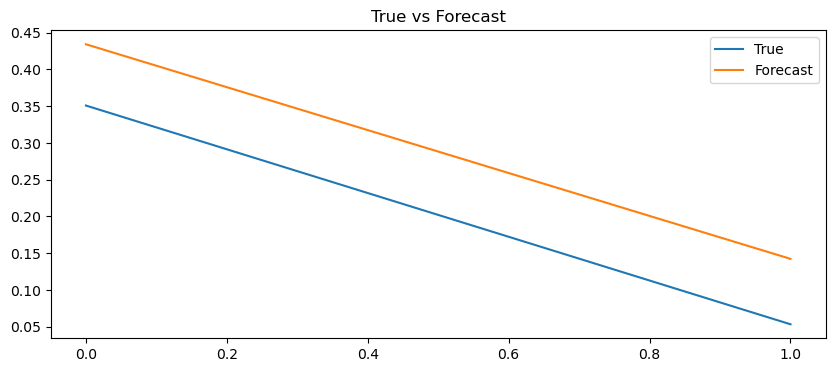

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(label['target'], label='True')
plt.plot(forecast.samples[0], label='Forecast')
plt.legend()
plt.title("True vs Forecast")
plt.show()

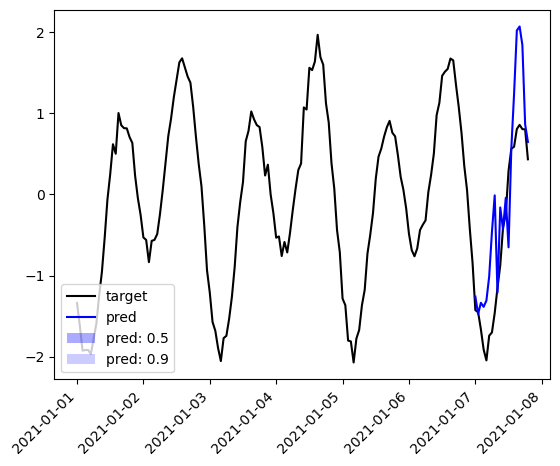

In [ ]:
plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)
plt.show()

In [ ]:
%run test_hf_connection.py

Status Code: 307
Headers:
{'Content-Type': 'text/plain; charset=utf-8', 'Content-Length': '260', 'Connection': 'keep-alive', 'Date': 'Sat, 28 Jun 2025 18:54:52 GMT', 'Location': '/api/resolve-cache/models/Salesforce/moirai-1.1-R-base/a0358780de4cdd7ac7963b12ae9985d225d55026/config.json?%2FSalesforce%2Fmoirai-1.1-R-base%2Fresolve%2Fmain%2Fconfig.json=&etag=%2221f44903cb12e12ba23d6afc0bbf4dfc0b2b296c%22', 'X-Powered-By': 'huggingface-moon', 'cross-origin-opener-policy': 'same-origin', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'X-Request-Id': 'Root=1-68603a7c-7a813756104fe1c53fb500b2', 'Access-Control-Allow-Origin': 'https://huggingface.co', 'Vary': 'Origin, Accept', 'Access-Control-Expose-Headers': 'X-Repo-Commit,X-Request-Id,X-Error-Code,X-Error-Message,X-Total-Count,ETag,Link,Accept-Ranges,Content-Range,X-Linked-Size,X-Linked-ETag,X-Xet-Hash', 'X-Repo-Commit': 'a0358780de4cdd7ac7963b12ae9985d225d55026', 'Accept-Ranges': 'bytes', 'X-Hub-Cache': 'MISS', 'Content-Disposition':